<a href="https://colab.research.google.com/github/tillu1208/OpenCV/blob/main/14_03_Facial_Landmark_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Facial Landmark Detection using OpenCV</h1>

Detecting facial landmarks such as the eyes, nose, and mouth is a natural extension to performing face detection since the bounding box for a face represents a natural starting point for detecting facial landmarks. Detecting facial landmarks has numerous applications including drowsy driver detection, emotion detection, virtual makeup, and HCI applications to ease communication for disabled people, to name a few. Facial feature detection is also referred to as “facial landmark detection”, “facial keypoint detection”, and “face alignment” in the literature, and you can use those keywords in Google for finding additional material on the topic. In this notebook, we will be using the OpenCV Facemark API to detect and plot facial landmark points on images. The API generates 68 landmarks as shown below. Facial landmark detection is performed in two steps.
### 1. Face Detection
We will continue to use the same SSD-based face detection model as in previous videos (implemented using the OpenCV DNN module).

**`res10_300x300_ssd_iter_140000.caffemodel`**



### 2. Facial Landmark Detetcion
For estimating the location of landmark points, we will use the OpenCV implementation of the paper titled [**Face Alignment at 3000 FPS via Regressing Local Binary Features**](http://www.jiansun.org/papers/CVPR14_FaceAlignment.pdf) by S. Ren et al., published in CVPR 2014.

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/10/c0-m14-face-landmark-feature-image.png" alt="face-landmark-feature-image">
</center>
<br>

### <font style="color:rgb(50,120,230)">Example Applications</font>

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/10/c0-m14-face-landmark-application-examples.png" alt="face-landmark-applications">
</center>
<br>


In [12]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/tmpmbzdxjjkjtoq/AAA3p1uP0DyR_Vry6tQNg423a?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

module-code.zip     100%[===================>] 116.41M  14.0MB/s    in 8.9s    
mapname:  conversion of  failed
replace face.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Readme.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace click.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace family.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace input-video.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace model/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace model/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace blink_detector.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace model/lbfmodel.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace face_with_points.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
y
replace Applications/boy.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace model/deploy.prototxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace Applications/family.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
rep

### Import Libraries

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,8)
matplotlib.rcParams['image.cmap'] = 'gray'

# 1. Preview Sample Image

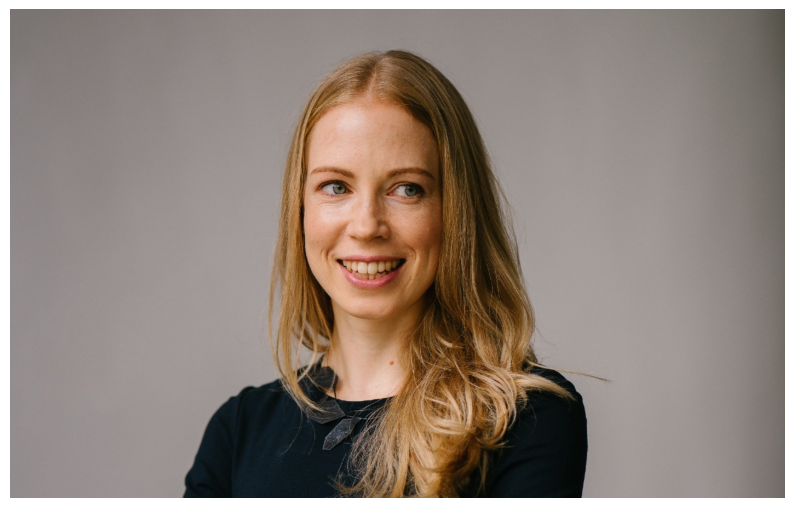

In [14]:
image_filename = 'face.jpg'
img = cv2.imread(image_filename)
plt.imshow(img[:,:,::-1]); plt.axis('off');

# 2. Face Detection

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

The following links are provided as references to this face detection model.

### <font style="color:rgb(8,133,37)">Caffe Model: res10_300x300_ssd_iter_140000</font>


* [**Model and Configuration Parameters**](https://github.com/opencv/opencv/blob/master/samples/dnn/models.yml)
<br>
* [**Model Architecture File**](https://github.com/opencv/opencv/blob/master/samples/dnn/face_detector/deploy.prototxt)
<br>

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>


[**`cv2.dnn.blobFromImage()`**](https://docs.opencv.org/4.5.2/d6/d0f/group__dnn.html#ga98113a886b1d1fe0b38a8eef39ffaaa0)
<br>
[**`cv2.dnn_Net.setInput()`**](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html#a5e74adacffd6aa53d56046581de7fcbd)
<br>
[**`cv2.dnn_Net.forward()`**](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html#a98ed94cb6ef7063d3697259566da310b)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

## 2.1 Load the Face Detection Model

In [15]:
# A smaller version of the model (FP16) is also provided.
# MODEL_PATH = './model/res10_300x300_ssd_iter_140000_fp16.caffemodel'

MODEL_PATH = './model/res10_300x300_ssd_iter_140000.caffemodel'
CONFIG_PATH = './model/deploy.prototxt'

# Load the face detection model.
net = cv2.dnn.readNetFromCaffe(CONFIG_PATH, MODEL_PATH)

## 2.2 Define a Convenience Function for Face Detection

In [16]:
def detect_faces(image, detection_threshold=0.70):

    # Convert to blob.
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123])

    # Pass the blob to the DNN model.
    net.setInput(blob)

    # Retrieve detections from the DNN model.
    detections = net.forward()

    # Create a list to store face bounding boxes.
    faces = []

    img_h = image.shape[0]
    img_w = image.shape[1]

    # Process the detections.
    for detection in detections[0][0]:
        if detection[2] >= detection_threshold:
            left   = detection[3] * img_w
            top    = detection[4] * img_h
            right  = detection[5] * img_w
            bottom = detection[6] * img_h

            face_w = right - left
            face_h = bottom - top

            face_roi = (left, top, face_w, face_h)
            faces.append(face_roi)

    return np.array(faces).astype(int)

## 2.3 Detect Faces

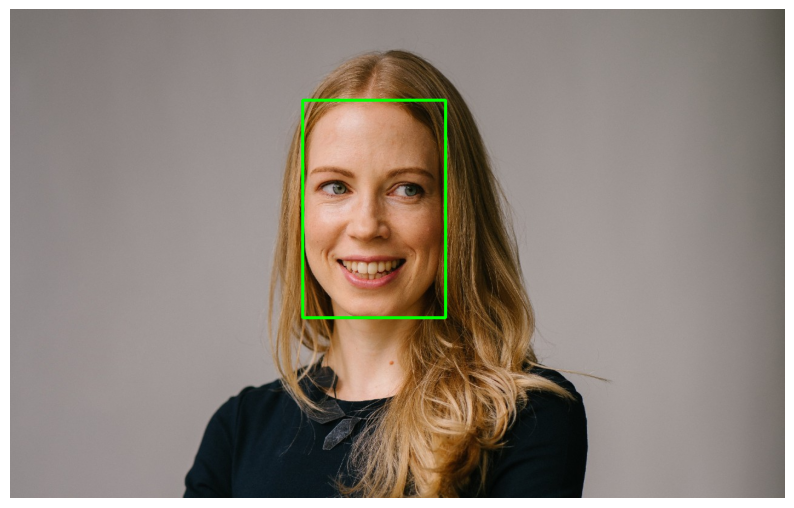

In [17]:
faces = detect_faces(img)

img_display = img.copy()

for face in faces:
    cv2.rectangle(img_display, face, (0,255,0), 3)

plt.imshow(img_display[...,::-1]); plt.axis('off');

# 3. Landmark Detection
Landmark detection involves three basic steps:
 - Create a detector object from the `FacemarkLBF` class
 - Load model using the `loadModel` method
 - Fit landmarks using the `fit` method

We create an instance of `createFacemarkLBF` class that implements the local binary features algorithm for feature detection and load the pre-trained detection model. [The model can be found here](https://github.com/kurnianggoro/GSOC2017/blob/master/data/lbfmodel.yaml)

## 3.1 Create Landmark Detector Object

In [18]:
# Create the landmark detector instance.
landmarkDetector = cv2.face.createFacemarkLBF()

# Load the model.
model = './model/lbfmodel.yaml'
landmarkDetector.loadModel(model)

## 3.2 Detect Landmarks

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(8,133,37)">Function Syntax </font>
``` python
retval, landmarks = cv2.face_Facemark.fit(image, faces)
```

`landmarks`:  The detected landmark points for each face.

The function has **2 required arguments**:

`image`:  The image with the faces for the which the landmarks are to be detected

`faces`:  The array of faces containing the bounding boxes for each face.


### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`face_Facemark.fit()`**](https://docs.opencv.org/4.5.3/db/dd8/classcv_1_1face_1_1Facemark.html#a9c21865859a685d16746f0097e9b3d26)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [19]:
# Detect Landmarks.
retval, landmarksList = landmarkDetector.fit(img, faces)

The `landmarkList` returned above is a list of arrays where each array contains the pixel coordinates of the 68 landmark points for each face detected. If multiple faces are detected in an image the `landmarkList` will contain an array of landmark points for each of the faces.

In [20]:
# First index in the list, "landmarksList[:]" refers to a specific array in the list.
print(landmarksList[0].shape)
print('')
print('                          x   y ')
print('                         -------')

print('First Landmark in list: ', landmarksList[0][0][0][0].astype(int),  landmarksList[0][0][0][1].astype(int))
print(' Last Landmark in list: ', landmarksList[0][0][67][0].astype(int), landmarksList[0][0][67][1].astype(int))
print('')
print(landmarksList)

(1, 68, 2)

                          x   y 
                         -------
First Landmark in list:  484 293
 Last Landmark in list:  579 440

(array([[[484.42075, 293.28546],
        [485.50082, 330.28622],
        [486.03458, 366.84067],
        [490.36694, 403.85678],
        [501.33087, 440.2019 ],
        [520.69006, 469.68314],
        [544.63617, 491.47708],
        [569.7113 , 514.6844 ],
        [596.2059 , 520.9227 ],
        [623.193  , 516.3024 ],
        [649.221  , 497.6645 ],
        [674.66345, 479.24106],
        [695.991  , 450.4259 ],
        [707.25104, 414.31247],
        [710.90906, 374.66928],
        [713.28186, 334.6696 ],
        [715.5199 , 295.35287],
        [494.13602, 272.85257],
        [512.2597 , 258.3137 ],
        [533.4167 , 258.09277],
        [554.59595, 264.02136],
        [575.05914, 275.52875],
        [611.3535 , 279.83817],
        [633.74005, 268.12833],
        [658.4533 , 262.02936],
        [683.26227, 266.4058 ],
        [701.9747 , 28

## 3.3 Display Landmarks with Numbers

68


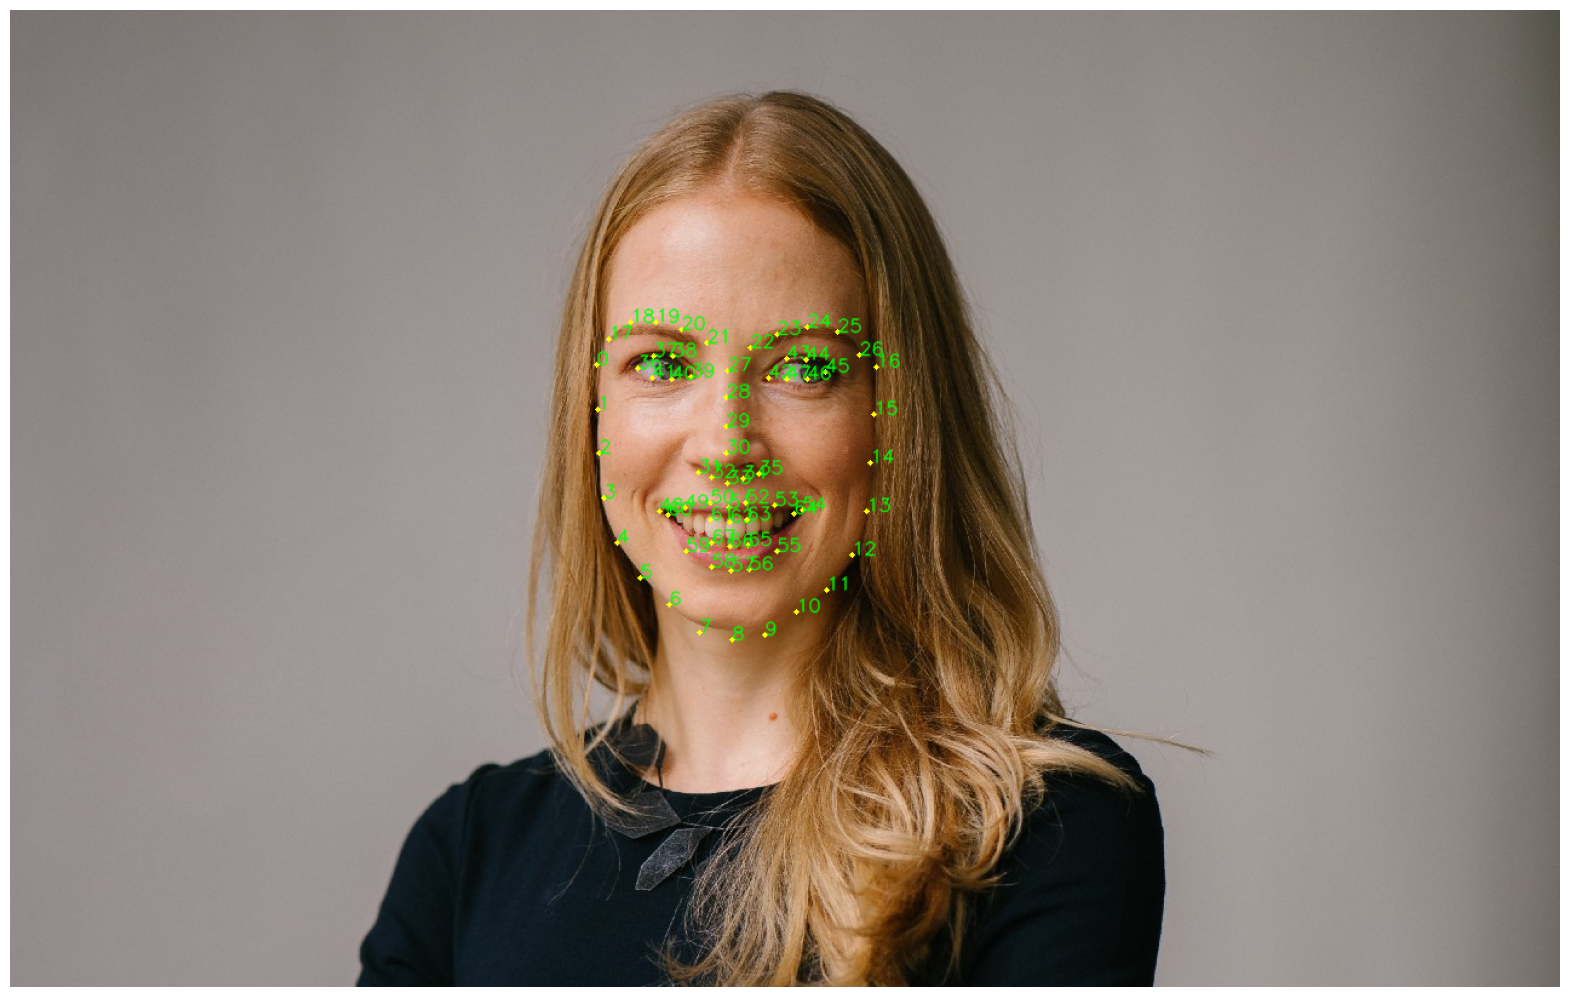

In [21]:
img_display = img.copy()
landmarks = landmarksList[0][0].astype(int)
print(len(landmarks))
for idx in range(len(landmarks)):
    cv2.circle(img_display, landmarks[idx], 2, (0,255,255), -1)
    cv2.putText(img_display, "{}".format(idx), landmarks[idx], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                cv2.LINE_AA)
plt.figure(figsize=(20,20))
plt.imshow(img_display[:,:,::-1]); plt.axis('off');

## 3.4 Draw Landmark Points
The Face Class in OpenCV has a built in function, `drawFacemarks()`, that draws the landmark points.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
``` python
cv2.face.drawFacemarks(image, points)
```

The function has **2 required arguments**:

* `image`: The image onto which the landmark points will be drawn
* `points`: The list of landmark points

The function has **1 optional argument**:

* `color`: The BGR color for the landmark points.
### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`drawFacemarks()`**](https://docs.opencv.org/4.5.3/db/d7c/group__face.html#ga318d9669d5ed4dfc6ab9fae2715310f5)


<hr style="border:none; height: 4px; background-color:#D3D3D3" />

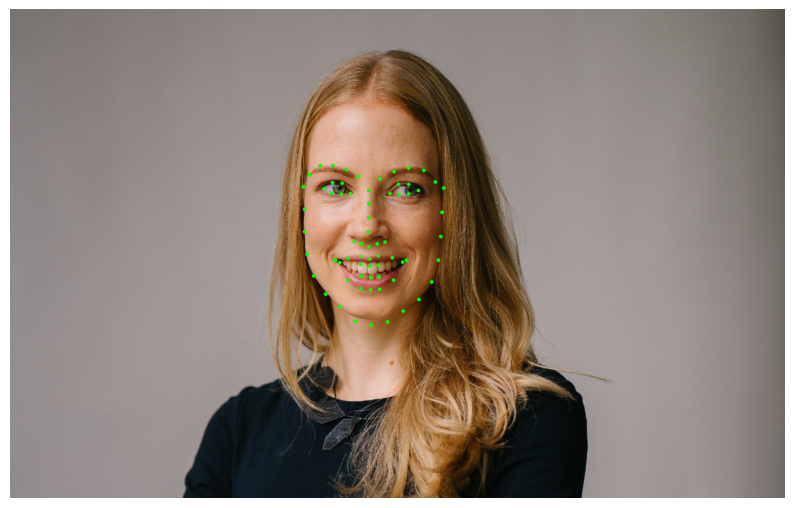

In [22]:
img_display = img.copy()
for landmarks in landmarksList:
    cv2.face.drawFacemarks(img_display, landmarks, (0, 255, 0))

plt.imshow(img_display[...,::-1]); plt.axis('off');

# 4. Integrated Implementation

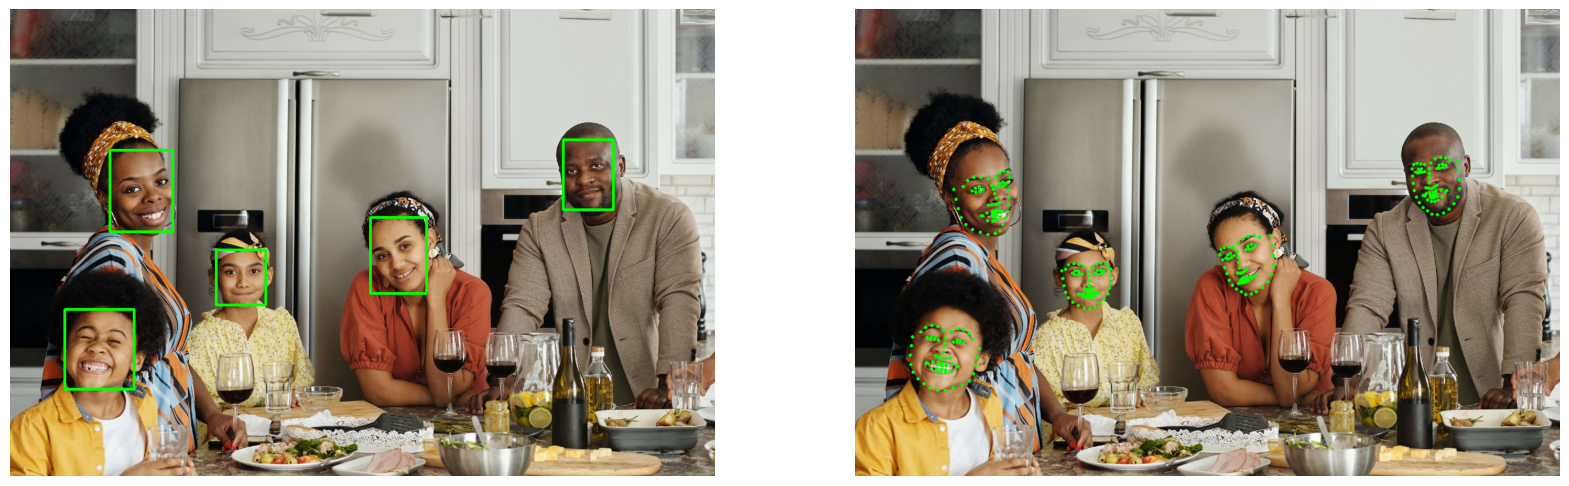

In [23]:
image_filename = 'family.jpg'
img = cv2.imread(image_filename)
img_display_faces = img.copy()
img_display_marks = img.copy()

# Detect the faces.
faces = detect_faces(img)

if len(faces) > 0:

    # Render bounding boxes.
    for face in faces:
        cv2.rectangle(img_display_faces, face, (0,255,0), 3)

    # Detect the facial landmarks.
    retval, landmarksList = landmarkDetector.fit(img, faces)

    # Render landmark points.
    for landmarks in landmarksList:
        cv2.face.drawFacemarks(img_display_marks, landmarks, (0, 255, 0))

    fig = plt.figure(figsize=(20,10))
    plt.subplot(121); plt.imshow(img_display_faces[...,::-1]); plt.axis('off');
    plt.subplot(122); plt.imshow(img_display_marks[...,::-1]); plt.axis('off');
else:
    print('No faces detected in image.')